# Credit Card Fraud Detection

**This project aims to detect fraudulent transactions using machine learning techniques. We'll explore the dataset, preprocess the data, build predictive models, and evaluate their performance.** 

## Loading all the necessary libraries

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

### Step 1: Loading and exploring the data set

In [5]:
#loading a small sample to explore the structure
df_sample=pd.read_csv('fraudTrain.csv',nrows=5000)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5000 non-null   int64  
 1   trans_date_trans_time  5000 non-null   object 
 2   cc_num                 5000 non-null   int64  
 3   merchant               5000 non-null   object 
 4   category               5000 non-null   object 
 5   amt                    5000 non-null   float64
 6   first                  5000 non-null   object 
 7   last                   5000 non-null   object 
 8   gender                 5000 non-null   object 
 9   street                 5000 non-null   object 
 10  city                   5000 non-null   object 
 11  state                  5000 non-null   object 
 12  zip                    5000 non-null   int64  
 13  lat                    5000 non-null   float64
 14  long                   5000 non-null   float64
 15  city

In [6]:
#optimizing datatypes for efficient memory usage
dtype_dict={
    'amt':'float32',
    'lat':'float32',
    'long':'float32',
    'is_fraud':'int8'
}  

In [7]:
#loading data
df_train_chunks=pd.read_csv('fraudTrain.csv',dtype=dtype_dict,chunksize=100000)
df_test_chunks=pd.read_csv('fraudTest.csv',dtype=dtype_dict,chunksize=100000)

In [8]:
#merging chunks to full data frame
dftrain=pd.concat(df_train_chunks)
dftest=pd.concat(df_test_chunks)

In [9]:
print(dftrain.info())
print(dftest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float32
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float32
 14  long              

In [10]:
df=pd.concat([dftrain,dftest])
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178101,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230003,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887798,-118.210503,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110001,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180801,-112.262001,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230598,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.959999,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462898,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


**Data successfully loaded**

## Step 2:Data Preprocessing and cleaning

In [13]:
print(dftrain.dtypes) #checking the datatypes of each column

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float32
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float32
long                     float32
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                    int8
dtype: object


In [14]:
print(df.isnull().sum()) #checking the null values

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [15]:
print("duplicate rows:",df.duplicated().sum()) #checking for the possibility of duplicate entries

duplicate rows: 0


In [16]:
print(df.shape)

(1852394, 23)


**Dataset contains 1.8M+ rows and 23 columns. No null or duplicate entries found**

## Step 3: Exploratory data analysis

### Check class disribution fraud vs non fraud

In [20]:
fraud_counts=df['is_fraud'].value_counts() #checking the total number of fraud and legitimate transactions
print(fraud_counts)


is_fraud
0    1842743
1       9651
Name: count, dtype: int64


### Visualize fraud vs non fraud transactions

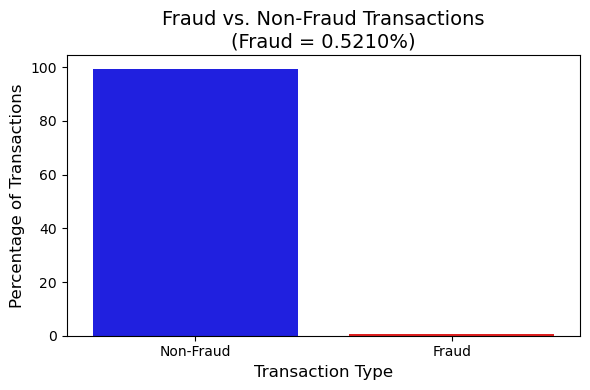

In [22]:
# Calculate Non-Fraud and Fraud transaction percentages
non_fraud_percent = (fraud_counts[0] / fraud_counts.sum()) * 100  # Percentage of Non-Fraud transactions
fraud_percent = (fraud_counts[1] / fraud_counts.sum()) * 100      # Percentage of Fraud transactions

# Set figure size
plt.figure(figsize=(6, 4))

# Plot a barplot showing the percentage of Non-Fraud and Fraud transactions
sns.barplot(x=['Non-Fraud', 'Fraud'],y=[non_fraud_percent, fraud_percent],palette=['blue', 'red'])                    # X-axis labels

# Add plot labels and title
plt.ylabel("Percentage of Transactions", fontsize=12)  # Y-axis label
plt.xlabel("Transaction Type", fontsize=12)           # X-axis label
plt.title(f"Fraud vs. Non-Fraud Transactions\n(Fraud = {fraud_percent:.4f}%)", fontsize=14)  # Title with Fraud %

# Improve layout for better visualization
plt.tight_layout()

# Display the plot
plt.show()


**Fraud is extremely rare.Only ~0.52% of transactions are fraudulent.
This confirms that we are dealing with a highly imbalanced dataset, which is common in real-world fraud detection.**

### Check frauds by transaction amounts

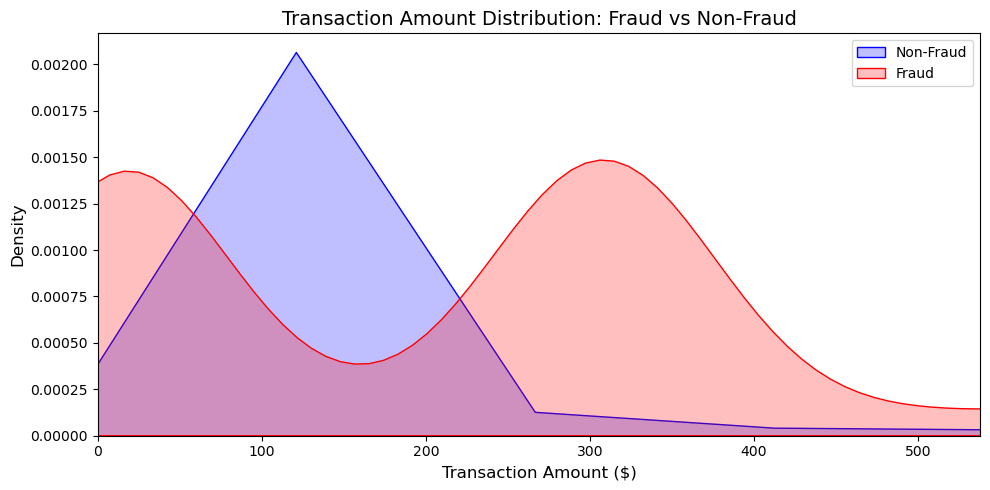

In [25]:
# Set the figure size for the plot
plt.figure(figsize=(10, 5))

# Plot Kernel Density Estimation (KDE) for Non-Fraudulent transactions
sns.kdeplot(df[df["is_fraud"] == 0]["amt"], label="Non-Fraud", color="blue", fill=True)
                   
# Plot KDE for Fraudulent transactions
sns.kdeplot(df[df["is_fraud"] == 1]["amt"], label="Fraud", color="red",fill=True)

# Limit the x-axis to focus on the 99th percentile of transaction amounts
# This removes extreme outliers for better visualization
plt.xlim(0, df["amt"].quantile(0.99))

# Add axis labels and title for clarity
plt.xlabel("Transaction Amount ($)", fontsize=12)  
plt.ylabel("Density", fontsize=12)                 
plt.title("Transaction Amount Distribution: Fraud vs Non-Fraud", fontsize=14)  

# Add legend to distinguish between Fraud and Non-Fraud distributions
plt.legend()

# Improve layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

**Fraudulent transactions are most likely to happen around $300-$400 and <$100.**

### Check which categories have most fraud

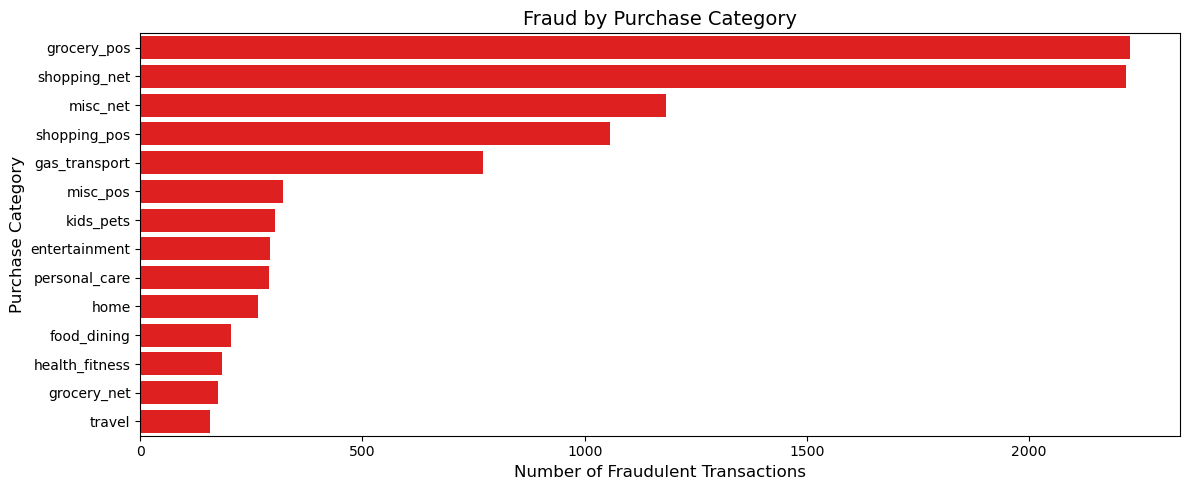

In [28]:
# Set the figure size for better readability
plt.figure(figsize=(12, 5))

# Filter the dataset to include only fraudulent transactions (is_fraud == 1)
df1 = df[df['is_fraud'] == 1]

# Count the number of fraud cases for each purchase category
category_counts = df1["category"].value_counts()

# Plot a horizontal countplot showing fraud frequency by purchase category
sns.countplot( y="category",data=df1,order=category_counts.index,color='red')

# Adding plot title and axis labels
plt.title("Fraud by Purchase Category", fontsize=14)  # Title of the plot
plt.xlabel("Number of Fraudulent Transactions", fontsize=12)  # X-axis label
plt.ylabel("Purchase Category", fontsize=12)  # Y-axis label

# Improve layout for better display
plt.tight_layout()

# Display the plot
plt.show()

**Top fraud categories are Grocery_pos,Shopping_net,Misc_net,Shopping_pos.
Fraudsters prefer categories with high transaction frequency and online purchases, which makes sense for card fraud.**

### Check fraud frequencies by state

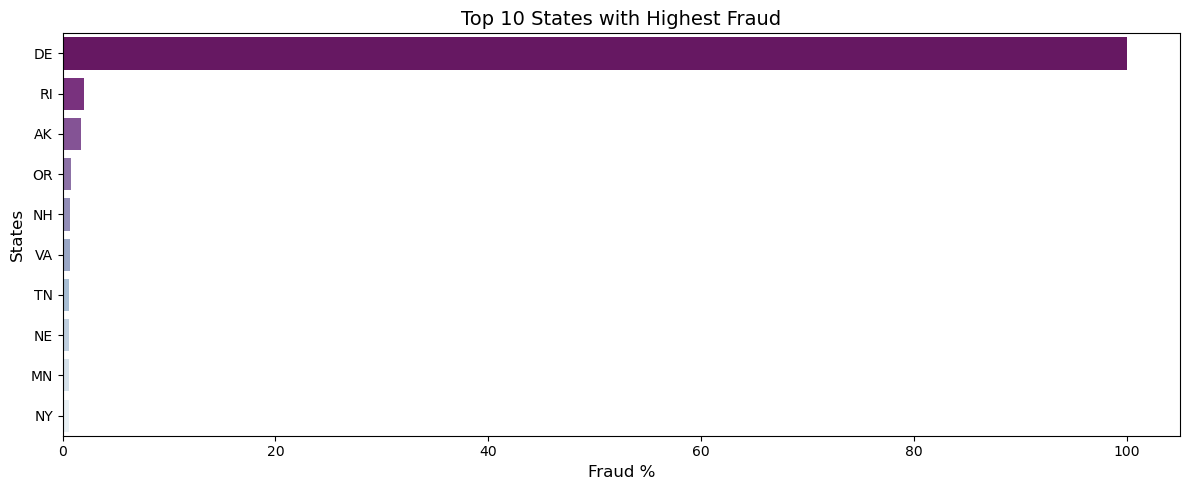

In [31]:
# Grouping by 'state' and calculating the mean of 'is_fraud' column, multiplying by 100 to get percentage
fraud_by_state = df.groupby("state")["is_fraud"].mean() * 100

# Sorting the states by fraud percentage in descending order
fraud_by_state = fraud_by_state.sort_values(ascending=False)

# Selecting the top 10 states with the highest fraud rates
top_10_states = fraud_by_state.head(10)

# Set figure size for better readability
plt.figure(figsize=(12, 5))

# Create a color palette for the bar plot (using BuPu color scheme)
palette = sns.color_palette("BuPu", n_colors=10)
palette.reverse()  # Reverse the palette so that the highest fraud is the darkest

# Plotting a horizontal barplot for top 10 states with the highest fraud rates
sns.barplot(y=top_10_states.index, x=top_10_states.values, palette=palette)

# Adding plot labels and title
plt.xlabel("Fraud %", fontsize=12)  # X-axis label
plt.ylabel("States", fontsize=12)   # Y-axis label
plt.title("Top 10 States with Highest Fraud", fontsize=14)  # Plot title

# Improve layout for better visualization
plt.tight_layout()

# Display the plot
plt.show()

**Delaware (DE) has the highest fraud percentage.
The distribution is highly skewed,some states have almost no fraud, while others (DE, RI, AK) show higher fraud rates.
Possible reasons: Weak fraud monitoring, low population but high fraud rate, or specific merchant vulnerabilities.The below link further justifies our finding.**
https://www.wmdt.com/2024/06/multiple-credit-card-skimmers-discovered-at-delaware-dollar-general-locations/

### Analyze fraudulent customers by age

In [34]:
#convert dob to age
df["dob"]=pd.to_datetime(df["dob"])
df["age"]=2025-df["dob"].dt.year                      

In [35]:
df.drop(columns=["dob"],inplace=True) #dropping the dob column since it becomes unnecessary
df.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,age
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.178101,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,37


In [36]:
df["age"] = pd.to_numeric(df["age"], errors="coerce")# Convert to numeric, setting errors to NaN if any

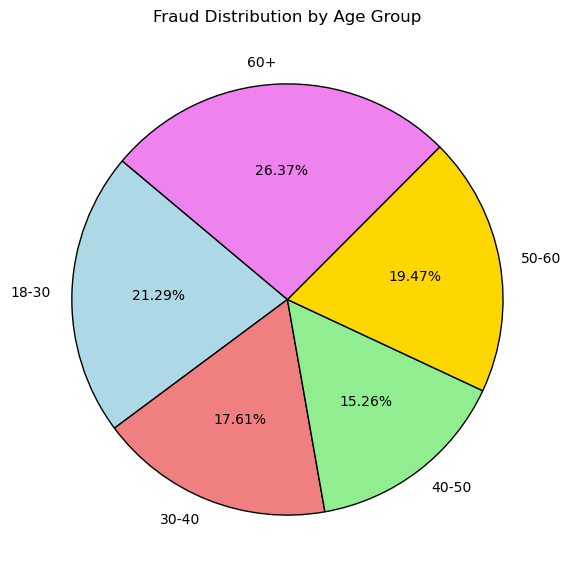

In [37]:
# Create Age Groups
df["age_group"] = pd.cut(df["age"], bins=[18, 30, 40, 50, 60, 100], 
                               labels=["18-30", "30-40", "40-50", "50-60", "60+"])

# Calculate fraud rate per age group
fraud_by_age = df.groupby("age_group")["is_fraud"].mean() * 100

# Define colors
colors = ["lightblue", "lightcoral", "lightgreen", "gold", "violet"]

# Create pie chart
plt.figure(figsize=(7,7))
plt.pie(fraud_by_age, labels=fraud_by_age.index, autopct="%1.2f%%", colors=colors, startangle=140, wedgeprops={"edgecolor": "black"})

# Add title
plt.title("Fraud Distribution by Age Group")
plt.show()

**Older age groups (60+) have the highest fraud rate (26.37%).
Young adults (18-30) also experience a notable amount of fraud (21.29%).
Possible explanation: Older adults may be more vulnerable to fraud schemes, while younger adults might be more engaged in digital transactions.**

### Fraud percentage by gender

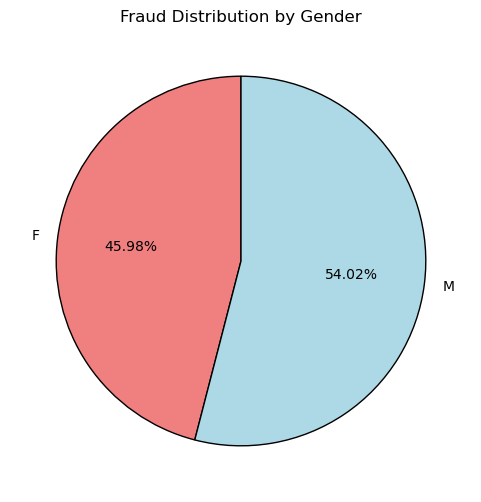

In [40]:
fraud_by_gender = df.groupby("gender")["is_fraud"].mean() * 100
colors = ["lightcoraL", "lightblue"]
labels = fraud_by_gender.index

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(fraud_by_gender, labels=labels, autopct="%1.2f%%", colors=colors, startangle=90, wedgeprops={"edgecolor": "black"})

# Add title
plt.title("Fraud Distribution by Gender")
plt.show()

**Males (54.02%) are slightly more involved in fraud than females (45.98%).
The difference isn’t huge but indicates a potential trend.**

## Step 4:Feature selection and engineering

### Dropping personal data (name, cc_num, street, dob, etc.) to avoid overfitting

In [44]:
# Select relevant columns
columns_to_keep = ['amt', 'category', 'merchant', 'zip', 'state', 'city', 'job', 'gender', 'age', 'is_fraud']

# Create a new DataFrame with only selected columns
df = df[columns_to_keep]

In [45]:
# Verify dataset structure
print(df.info())

# Display first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   amt       float32
 1   category  object 
 2   merchant  object 
 3   zip       int64  
 4   state     object 
 5   city      object 
 6   job       object 
 7   gender    object 
 8   age       int32  
 9   is_fraud  int8   
dtypes: float32(1), int32(1), int64(1), int8(1), object(6)
memory usage: 129.0+ MB
None


,amt,category,merchant,zip,state,city,job,gender,age,is_fraud
0,4.970000,misc_net,"fraud_Rippin, Kub and Mann",28654,NC,Moravian Falls,"Psychologist, counselling",F,37,0
1,107.230003,grocery_pos,"fraud_Heller, Gutmann and Zieme",99160,WA,Orient,Special educational needs teacher,F,47,0
2,220.110001,entertainment,fraud_Lind-Buckridge,83252,ID,Malad City,Nature conservation officer,M,63,0
3,45.000000,gas_transport,"fraud_Kutch, Hermiston and Farrell",59632,MT,Boulder,Patent attorney,M,58,0
4,41.959999,misc_pos,fraud_Keeling-Crist,24433,VA,Doe Hill,Dance movement psychotherapist,M,39,0


### Encoding the categorical variables 

In [47]:
# List of categorical columns to encode
label_cols = ['category', 'merchant', 'state', 'city', 'job', 'gender']
label_encoders = {}

# Apply Label Encoding to convert categories into numbers
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Transform the column
    label_encoders[col] = le  # Store encoder for future use

# Verify encoding
print(df.head())


          amt  category  merchant    zip  state  city  job  gender  age  \
0    4.970000         8       514  28654     27   532  372       0   37   
1  107.230003         4       241  99160     47   619  431       0   47   
2  220.110001         0       390  83252     13   474  308       1   63   
3   45.000000         2       360  59632     26    84  330       1   58   
4   41.959999         9       297  24433     45   217  116       1   39   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  


### Fixing data imbalance using SMOTE method

In [49]:
# Define X (features) and y (target)
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Apply SMOTE with a smaller sampling ratio to avoid memory issues
smote = SMOTE(sampling_strategy=0.4, random_state=42)  # Adjust if needed
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print class distribution after SMOTE
print("After SMOTE balancing:", y_resampled.value_counts())

After SMOTE balancing: is_fraud
0    1842743
1     737097
Name: count, dtype: int64


## Step 5:Model training and evaluation

In [51]:
# Define X (features) and y (target)
X = X_resampled  # SMOTE-processed features
y = y_resampled  # SMOTE-processed target

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution in train & test sets
print("Train Class Distribution:\n", y_train.value_counts())
print("Test Class Distribution:\n", y_test.value_counts())

Train Class Distribution:
 is_fraud
0    1474194
1     589678
Name: count, dtype: int64
Test Class Distribution:
 is_fraud
0    368549
1    147419
Name: count, dtype: int64


In [52]:
# Define the XGBoost model
model = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handles imbalance
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)



### Evaluate performance

In [54]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[359529   9020]
 [  8994 138425]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    368549
           1       0.94      0.94      0.94    147419

    accuracy                           0.97    515968
   macro avg       0.96      0.96      0.96    515968
weighted avg       0.97      0.97      0.97    515968



**The overall (macro average) performance metrics for the XGBoost model are:**
- **Accuracy: 97%**
- **Precision: 0.96**
- **Recall: 0.96**
- **F1-Score: 0.96**

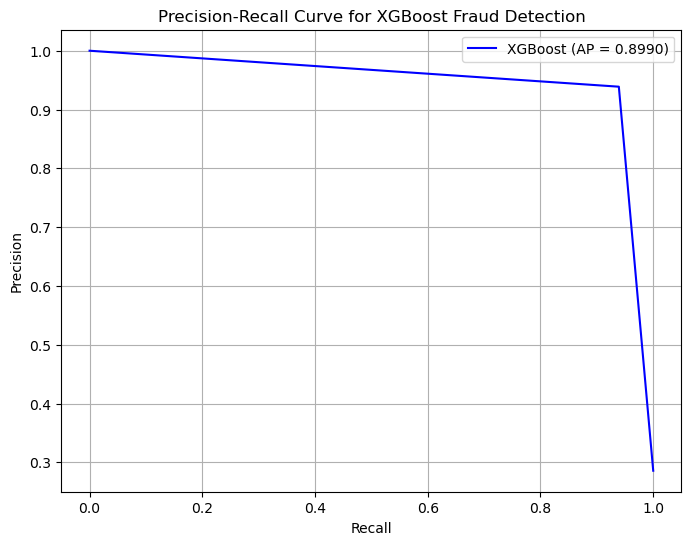

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming y_test is your actual labels and y_pred_proba are predicted probabilities
# For XGBoost, use predict_proba to get probabilities
# y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AP = {avg_precision:.4f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost Fraud Detection')
plt.legend(loc='best')
plt.grid()
plt.show()


**Average Precision of the model is 0.8990.The model maintains high precision (>0.9) across most recall values, suggesting it effectively detects fraud while minimizing false positives.**

### Checking the ROC curves

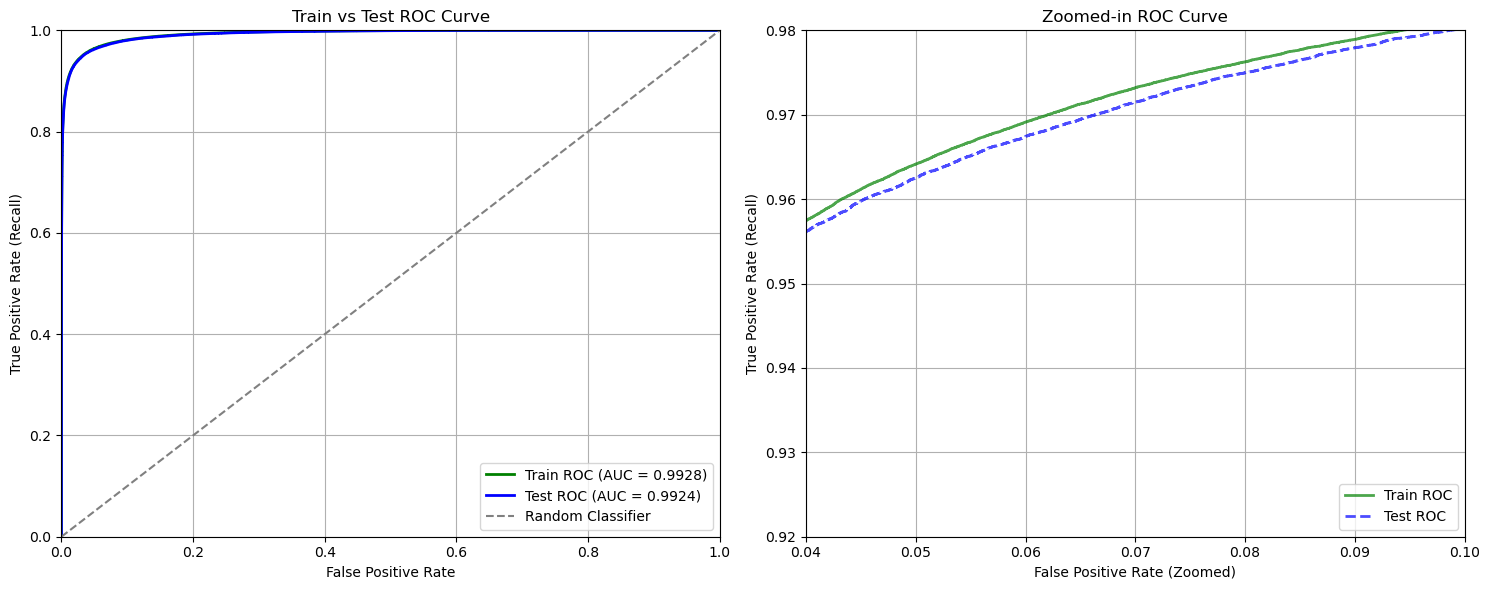

Train AUC: 0.9928
Test AUC: 0.9924


In [59]:
# Get probability predictions for both Train and Test sets
y_train_probs = model.predict_proba(X_train)[:, 1]
y_test_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Train
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for Test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
roc_auc_test = auc(fpr_test, tpr_test)


# Create Subplots for ROC and Zoomed-in View
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Full ROC Curve
axes[0].plot(fpr_train, tpr_train, color='green', lw=2, label=f'Train ROC (AUC = {roc_auc_train:.4f})')
axes[0].plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')  # Diagonal line

# Plot settings for Full ROC
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].set_title("Train vs Test ROC Curve")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Plot 2: Zoomed-in ROC Curve
axes[1].plot(fpr_train, tpr_train, color='green', linestyle='-', lw=2, alpha=0.7, label='Train ROC')
axes[1].plot(fpr_test, tpr_test, color='blue', linestyle='--', lw=2, alpha=0.7, label='Test ROC')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')

# Zoom into top-left corner (low FPR, high TPR)
axes[1].set_xlim([0.04, 0.1])
axes[1].set_ylim([0.92, 0.98])

# Plot settings for Zoomed-in ROC
axes[1].set_xlabel("False Positive Rate (Zoomed)")
axes[1].set_ylabel("True Positive Rate (Recall)")
axes[1].set_title("Zoomed-in ROC Curve")
axes[1].legend(loc="lower right")
axes[1].grid(True)

# Final Layout and Display
plt.tight_layout()
plt.show()

# Print AUC Scores
print(f"Train AUC: {roc_auc_train:.4f}")
print(f"Test AUC: {roc_auc_test:.4f}")



**The model demonstrates strong generalization with minimal overfitting, achieving near-perfect discrimination between fraudulent and non-fraudulent transactions on both train and test data.**
- **Train AUC: 0.9928**
- **Test AUC: 0.9924**

### Checking feature importance of the XGBoost model

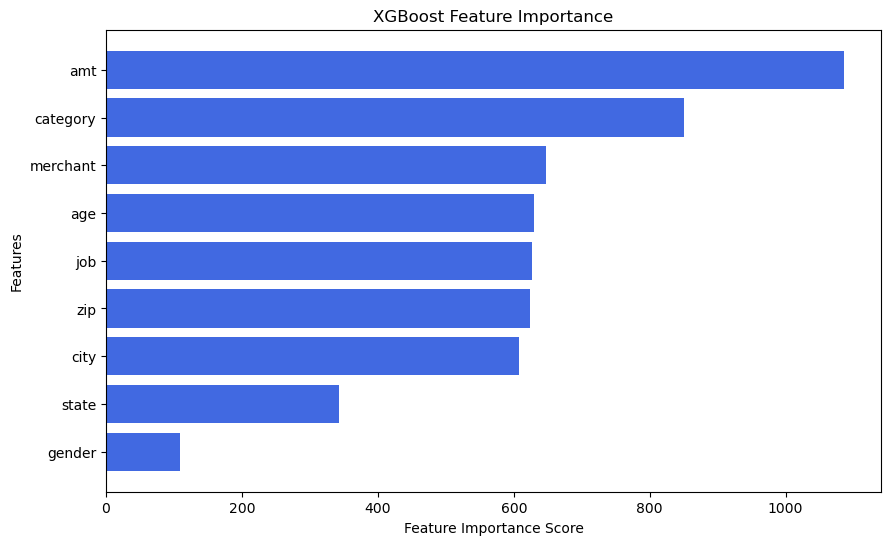

,Feature,Importance
0,amt,1086.0
1,category,851.0
2,merchant,648.0
8,age,629.0
6,job,627.0
3,zip,624.0
5,city,608.0
4,state,343.0
7,gender,109.0


In [62]:
feature_importance = model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame for easy sorting
importance_df = pd.DataFrame({'Feature': list(feature_importance.keys()), 
                              'Importance': list(feature_importance.values())})

# Sort features by importance (highest first)
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='royalblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

# Print importance values
importance_df

**The model appears to be heavily influenced by transaction-specific details (amount, category, merchant) rather than user demographics (gender, age) or broad locations (state).
This indicates fraud is more behavior-driven than demographic-driven in this dataset.**